# Learning NLP Tutorial Series
## Tutorial 2: Topics on Application of NLP Techniques (on gender framing, parties' political communication, and so on)



## **Overview**

* [Gender framing in political tweets](#section1)
* [Party affiliation prediction](#section2)
* [Topic Modeling](#section3)







<a id="@section1"></a>
# **Gender framing, in political tweets**

## Notebook Introduction

In this notebook, we are going to use some of the techniques we used for text classification, in order to gain some insights about the the way some topics or situation are framed in political communication and speeches.

In particular, we are going to use a datasets of Tweets tweeted by politicians belonging to the House of Representative in the US. 

The first type of analysis tries to replicate the type of analysis done in the paper "Gendered Language on the Economics Job Market Rumors Forum" by Alice Wu (available here: https://scholar.harvard.edu/files/alicewu/files/gendered_language_2018.pdf). In her paper, Alice This paper examines the existence of an unwelcoming or stereotypical culture using evidence on how women and men are portrayed in anonymous discussions on the Economics Job Market Rumors forum (EJMR) (a forum where economists can discuss about different topics, from topics regarding economics, jobs, interviews, and beyond, with also post about topics unrelated to economics). She uses a Lasso-Logistic model to measure gendered language in EJMR postings, identifying the words that are most strongly associated with discussions about one gender or the other.  She finds that the words most predictive of a post about a woman are typically about physical appearance or personal information, whereas those most predictive of a post about a man tend to focus on academic or professional characteristics.


Let's start our project!

In [ ]:
import pandas as pd
import numpy as np
import spacy 
import gensim

import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#!pip install genism

In [ ]:
###!!! Qui, decidere come fare l'upload del dataset.....!!

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Datasets!/twitter_politiciansUSA/tweets_house_repres29marz21_01.csv')
len(df)

37624

First of all, we are going to analyze our dataset, and see how many politicians we have. From the list below, we can see that we have a different number of tweets for each politician.

In [ ]:
print(df['screen_name'].value_counts())

print('\nThe total number of politicians in this dataset is ' + str(df['screen_name'].nunique()))

RepChuyGarcia     3238
GReschenthaler    2951
RepAndyKimNJ      2217
RepFredKeller     2213
RepFitzgerald     2171
                  ... 
RepPatFallon        72
RepKahele           72
RepTroyNehls        66
RepMrvan            57
RepBentz            43
Name: screen_name, Length: 69, dtype: int64

The total number of politicians in this dataset is 69


In [ ]:
#####!!!!! Qui, decidere se già dare il dataset finale, con tweets e caratteristiche, tutte assieme!! :)

In [ ]:
df_info = pd.read_csv('/content/gdrive/My Drive/Datasets!/twitter_politiciansUSA/active_accounts-21febr2021.csv')
#df_info

In [ ]:
df.head(4)

,Unnamed: 0,text,Created_at,Tweet_ID,Geo,favorite_count,Language,retweet_count,coordinates,if_retweet,screen_name,User_name,User_location,User_description,followers_count,verified_user,url_user,id_user,hashtags,urls
0,0,b'Maintaining trust with the public is the mos...,2021-03-26 19:34:35,1375531646867374083,NaN,82,en,52,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/WuKSjiJZC9', 'expanded_..."
1,1,b'Tune into @newsmax this morning at 7:50 ET\x...,2021-03-26 11:10:39,1375404829812621313,NaN,4,en,0,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/TBIsZAxWuM', 'expanded_..."
2,2,b'Reminder to #WI05 artists \xf0\x9f\x91\x89 t...,2021-03-25 13:38:07,1375079551991230465,NaN,2,en,0,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,"[{'text': 'WI05', 'indices': [12, 17]}]","[{'url': 'https://t.co/UQeizLcojB', 'expanded_..."
3,3,b'\xf0\x9f\xa7\xb5Great thread from my colleag...,2021-03-24 20:28:22,1374820406868205579,NaN,4,en,0,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/TNcrCFgvMV', 'expanded_..."


In [ ]:
df_info.head(4)

,user_name,twitter_id,party_name,state,office_title,account_type,first_name,middle_name,last_name,suffix,status,collecting,showing,bioguide_id,gender,fec_candidate_id,district,branch
0,SenOssoff,1356714265894408196,Democrat,GA,Senator,official,Jon,NaN,Ossoff,NaN,1,True,True,O000174,M,S8GA00180,0.0,S
1,EverettStern1,1302611901613039617,Republican,PA,Senate Candidate,campaign,Everett,NaN,Stern,NaN,1,True,True,NaN,M,S2PA00315,0.0,S
2,JohnDMcGuigan,232189982,Democrat,PA,Senate Candidate,campaign,John,NaN,McGuigan,NaN,1,True,True,NaN,M,S2PA00307,0.0,S
3,DeBellisforSen,733491336742113280,Republican,PA,Senate Candidate,campaign,John,NaN,DeBellis,NaN,1,True,True,NaN,M,S2PA00323,0.0,S


In [ ]:
df_all = pd.merge(df, df_info, left_on='screen_name', right_on='user_name', indicator= True)
df_all.head(4)
#### !!! Il default è un join "inner" (cioè, piglia l'intersezione dei due dataset......!!)  (però ci può stare, perchè
####    il mio "left dataset" è un sottoinsieme dei nomi presenti nel mio "right dataset".....!!)

,Unnamed: 0,text,Created_at,Tweet_ID,Geo,favorite_count,Language,retweet_count,coordinates,if_retweet,screen_name,User_name,User_location,User_description,followers_count,verified_user,url_user,id_user,hashtags,urls,user_name,twitter_id,party_name,state,office_title,account_type,first_name,middle_name,last_name,suffix,status,collecting,showing,bioguide_id,gender,fec_candidate_id,district,branch,_merge
0,0,b'Maintaining trust with the public is the mos...,2021-03-26 19:34:35,1375531646867374083,NaN,82,en,52,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/WuKSjiJZC9', 'expanded_...",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both
1,1,b'Tune into @newsmax this morning at 7:50 ET\x...,2021-03-26 11:10:39,1375404829812621313,NaN,4,en,0,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/TBIsZAxWuM', 'expanded_...",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both
2,2,b'Reminder to #WI05 artists \xf0\x9f\x91\x89 t...,2021-03-25 13:38:07,1375079551991230465,NaN,2,en,0,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,"[{'text': 'WI05', 'indices': [12, 17]}]","[{'url': 'https://t.co/UQeizLcojB', 'expanded_...",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both
3,3,b'\xf0\x9f\xa7\xb5Great thread from my colleag...,2021-03-24 20:28:22,1374820406868205579,NaN,4,en,0,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/TNcrCFgvMV', 'expanded_...",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both


In [ ]:
print(df_all['_merge'].value_counts())

both          37624
right_only        0
left_only         0
Name: _merge, dtype: int64


As done in the first tutorial, we are going to preprocess the text, in order to optimize our predictive performances. The steps we are going to follow are: putting all the text in lowercases, removing punctuation, words containing numbers, and text in square brackets. Finally, we are going to reduce each word to its characteristic stem.

In [ ]:
#### Preprocessing

def clean_text(text):
#''', , and '''
#Make text lowercase   
 text = text.lower()
#remove text in square brackets
 text = re.sub(r'\[.*?\]', '', text)
#remove punctuation   
 text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) 
#remove words containing numbers
 text = re.sub(r'\w*\d\w*', '', text)

#Stemming
 return gensim.parsing.preprocessing.stem_text(text)
#return text

df_all['text_clean'] = pd.DataFrame(df_all.text.apply(lambda x: clean_text(x)))

In [ ]:
df_all.head(4)

,Unnamed: 0,text,Created_at,Tweet_ID,Geo,favorite_count,Language,retweet_count,coordinates,if_retweet,screen_name,User_name,User_location,User_description,followers_count,verified_user,url_user,id_user,hashtags,urls,user_name,twitter_id,party_name,state,office_title,account_type,first_name,middle_name,last_name,suffix,status,collecting,showing,bioguide_id,gender,fec_candidate_id,district,branch,_merge,text_clean
0,0,b'Maintaining trust with the public is the mos...,2021-03-26 19:34:35,1375531646867374083,NaN,82,en,52,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/WuKSjiJZC9', 'expanded_...",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,bmaintain trust with the public is the most fu...
1,1,b'Tune into @newsmax this morning at 7:50 ET\x...,2021-03-26 11:10:39,1375404829812621313,NaN,4,en,0,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/TBIsZAxWuM', 'expanded_...",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,btune into newsmax thi morn at be speak with f...
2,2,b'Reminder to #WI05 artists \xf0\x9f\x91\x89 t...,2021-03-25 13:38:07,1375079551991230465,NaN,2,en,0,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,"[{'text': 'WI05', 'indices': [12, 17]}]","[{'url': 'https://t.co/UQeizLcojB', 'expanded_...",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,bremind to artist the deadlin for the annual c...
3,3,b'\xf0\x9f\xa7\xb5Great thread from my colleag...,2021-03-24 20:28:22,1374820406868205579,NaN,4,en,0,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/TNcrCFgvMV', 'expanded_...",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,thread from my colleagu warrendavidson detail ...


Now, I want to select those tweets that mention or talk about women.

In order to do so, for each tweets I will check whether the text of the tweets contains the following words:  
'woman', 'women', 'girl', 'girlfriend', 'mother', 'daughter', 'actress', 'wife', 'chairwoman', 'spokewoman', 'aunt', 'bride', 'female', 'fiancee', 'granddaughter', 'grandma', 'grandmother', 'herself', 'lady', 'ladies', 'niece', 'sister', 'waitress'.

This approach is similar to the approach used in the study of Neal Caren of 2013. Neal applied a gender-based analysis of text to New York Times articles to see whether male and female words appear in different contexts, and she found that this is actually the case. She stated that "if your knowledge of men's and women's roles in society came just from reading last weeks's New York Times, you would think that men play sports and run the government. Women do feminine and domestic things".
(The article is called "Using Python to see how the Times write about men and women" (2013) by Neal Caren, and you can find the notebook of her analysis here: https://nbviewer.jupyter.org/gist/nealcaren/5105037  )

We will categorized tweets that mention one of these words with a dummy, equal to 1 if one of these words appear, and zero otherwise.

In [ ]:
list_female = ['woman', 'women', 'girl', 'girlfriend', 'mother', 'daughter', 'actress', 'wife', 'chairwoman', 'spokewoman', 'aunt', 'bride', 'female', 'fiancee', 'granddaughter', 'grandma', 'grandmother', 'herself', 'lady', 'ladies', 'niece', 'sister', 'waitress']
def word_in_phrase_female(data):
  for i in list_female:
    if i in data['text_clean']:
      return 1
  else:
    return 0

In [ ]:
df_all['female_talking'] = df_all.apply(word_in_phrase_female, axis = 1)

print(df_all['female_talking'].value_counts())

0    36537
1     1087
Name: female_talking, dtype: int64


Let's explore which kind of tweets are selected:

In [ ]:
pd.set_option('display.max_colwidth', -1)
df_female_talk = df_all[df_all['female_talking']==1]
df_female_talk.head(4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,text,Created_at,Tweet_ID,Geo,favorite_count,Language,retweet_count,coordinates,if_retweet,screen_name,User_name,User_location,User_description,followers_count,verified_user,url_user,id_user,hashtags,urls,user_name,twitter_id,party_name,state,office_title,account_type,first_name,middle_name,last_name,suffix,status,collecting,showing,bioguide_id,gender,fec_candidate_id,district,branch,_merge,text_clean,female_talking
130,130,"b'This bill puts working men, women, and families of our state first, by extending a lifeline to the recently unemplo\xe2\x80\xa6 https://t.co/5lubw7yxzG'",2020-04-15 17:26:37,1250475630275096576,NaN,3,en,2,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin","Official account for Congressman Scott Fitzgerald, proudly serving Wisconsin’s Fifth District. #WI05",8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/5lubw7yxzG', 'expanded_url': 'https://twitter.com/i/web/status/1250475630275096576', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,bthi bill put work men women and famili of our state first by extend a lifelin to the recent,1
185,185,"b'As a veteran, I was honored to work with some of the finest men and women serving the nation. Thank you to all who\xe2\x80\xa6 https://t.co/YANZIE7Rrg'",2019-11-11 19:59:20,1193981556186124298,NaN,10,en,9,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin","Official account for Congressman Scott Fitzgerald, proudly serving Wisconsin’s Fifth District. #WI05",8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/YANZIE7Rrg', 'expanded_url': 'https://twitter.com/i/web/status/1193981556186124298', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [116, 139]}]",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,ba a veteran i wa honor to work with some of the finest men and women serv the nation thank you to all,1
335,335,"b""Congratulations to Juliet Nowak from @angelslci who won the Governor's Trailblazer Award for Woman in Business! Hop\xe2\x80\xa6 https://t.co/Ygpy4lxCMt""",2018-05-23 21:40:09,999404642952990721,NaN,1,en,1,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin","Official account for Congressman Scott Fitzgerald, proudly serving Wisconsin’s Fifth District. #WI05",8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/Ygpy4lxCMt', 'expanded_url': 'https://twitter.com/i/web/status/999404642952990721', 'display_url': 'twitter.com/i/web/status/9…', 'indices': [117, 140]}]",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,bcongratul to juliet nowak from angelslci who won the governor trailblaz award for woman in busi,1
724,724,b'Happy #InternationalWomensDay! Get to know some of the important women who have made Wisconsin history: https://t.co/5UnNL1tVeq',2017-03-08 16:02:21,839506585596616705,NaN,1,en,3,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin","Official account for Congressman Scott Fitzgerald, proudly serving Wisconsin’s Fifth District. #WI05",8598,True,https://t.co/7rWSAAN9xM,1004891731,"[{'text': 'InternationalWomensDay', 'indices': [6, 29]}]","[{'url': 'https://t.co/5UnNL1tVeq', 'expanded_url': 'https://twitter.com/travelwi/status/839505244686020610', 'display_url': 'twitter.com/travelwi/statu…', 'indices': [104, 127]}]",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,bhappi internationalwomensdai get to know some of the import women who have made wisconsin histori,1


We are now going to prepare the dataset, in order to predict to which category the tweets belong to, based on his words.

In [ ]:
df_short = df_all[['text_clean','female_talking']]
df_short.head(4)

,text_clean,female_talking
0,bmaintain trust with the public is the most fu...,0
1,btune into newsmax thi morn at be speak with f...,0
2,bremind to artist the deadlin for the annual c...,0
3,thread from my colleagu warrendavidson detail ...,0


One important thing we have to consider (and we must NOT forget!!) is that we have to eliminate the words that represent women/female, that we used in order to categorize the tweets. If we keep them and we train the model on the text, the exercise is pretty "trivial", since it's enough to find one of the words we used to categorized the tweets as "female talking" in order to predict its category.

In [ ]:
list_female = ['woman', 'women', 'girl', 'girlfriend', 'mother', 'daughter', 'actress', 'wife', 'chairwoman', 'spokewoman', 'aunt', 'bride', 'female', 'fiancee', 'granddaughter', 'grandma', 'grandmother', 'herself', 'lady', 'ladies', 'niece', 'sister', 'waitress']

def cleaning_text(text):
  for word in list_female:
    text = re.sub(word, '', text)
  return text

In [ ]:
df_short['text_clean02'] = df_short['text_clean'].apply(cleaning_text)
df_short[df_short['female_talking']==1].head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text_clean,female_talking,text_clean02
130,bthi bill put work men women and famili of our state first by extend a lifelin to the recent,1,bthi bill put work men and famili of our state first by extend a lifelin to the recent
185,ba a veteran i wa honor to work with some of the finest men and women serv the nation thank you to all,1,ba a veteran i wa honor to work with some of the finest men and serv the nation thank you to all
335,bcongratul to juliet nowak from angelslci who won the governor trailblaz award for woman in busi,1,bcongratul to juliet nowak from angelslci who won the governor trailblaz award for in busi
724,bhappi internationalwomensdai get to know some of the import women who have made wisconsin histori,1,bhappi internationalsdai get to know some of the import who have made wisconsin histori
1172,brt travelwi at state park you just see mother natur meet her facetofac travelwi,1,brt travelwi at state park you just see natur meet her facetofac travelwi
1347,bthi is a great stori of a hardwork amp compassion young person amp daughter of on of my colleagu johnjagl,1,bthi is a great stori of a hardwork amp compassion young person amp of on of my colleagu johnjagl
1589,bwho happi now wisconsin dairi cow get the edg on their bovin sister in california via lacrossetribun,1,bwho happi now wisconsin dairi cow get the edg on their bovin in california via lacrossetribun
1934,brt wdnr good morn hunter the gundeer season is under wai stai safe out there and have a fun hunt wardengirl wihunt,1,brt wdnr good morn hunter the gundeer season is under wai stai safe out there and have a fun hunt warden wihunt
1937,btodai wdnr chat discuss program to get more women and youth involv in wi outdoor sport tune in at noon,1,btodai wdnr chat discuss program to get more and youth involv in wi outdoor sport tune in at noon
1939,btodai is snowplow driver appreci dai in wi thank to the over men amp women who help keep our road safe,1,btodai is snowplow driver appreci dai in wi thank to the over men amp who help keep our road safe


We are now going to start the usual process for supervised machine learning: that is, splitting the dataset in training and test dataset, training the model in the training dataset, and then apply the model in the test dataset, to see how well it predict our dependent variable.

Let's underline that the aim of this project/exercise is not to predict the category based on the text, but to understand which are the contexts in which women are mention in political tweets and debates.

 **Question:** How do you expect we are going to deal with this aim of the project.....?

In [ ]:
### I now split in training and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_short['text_clean02'], df_short['female_talking'], test_size=0.25, random_state=35)

In [ ]:
X_train.head(4)

9170     bi am heartbroken my prayer ar with thi famili nni am at a loss for word i am speechless                                     
27871    byouv heard me talk a lot about how the va ha fail the veteran of nj but were not the onli on proud to                       
34678    bim hold a commun convers in each counti thi summer on mondai at ill host on for httpstcomzcdvgjffh                          
12650    bthe scene on the floor earlier todai wa disturb polic and a few of us stood togeth to protect the chamber httpstcoaatslkauwn
Name: text_clean02, dtype: object

In [ ]:
y_train.head(4)

9170     0
27871    0
34678    0
12650    0
Name: female_talking, dtype: int64

In [ ]:
### We create the dictionary
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [ ]:
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
features_name = vectorizer.get_feature_names()
features_name[:10]

['aaa',
 'aaajaajc',
 'aaajchicago',
 'aacronthehil',
 'aaf',
 'aagonzalezjr',
 'aampt',
 'aapchotweet',
 'aapi',
 'aapiequalpai']

In [ ]:
len(features_name)

27466

In [ ]:
X_train_counts

<28218x27466 sparse matrix of type '<class 'numpy.int64'>'
	with 433840 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [ ]:
### Train a Classifier - Fitting the model
from sklearn.linear_model import LogisticRegression
regression = LogisticRegression()
regression.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Ww now proceed with the usual prediction exercise

In [ ]:
### Prediction
X_test_counts = vectorizer.transform(X_test)
features_name = vectorizer.get_feature_names()
features_name[:10]

['aaa',
 'aaajaajc',
 'aaajchicago',
 'aacronthehil',
 'aaf',
 'aagonzalezjr',
 'aampt',
 'aapchotweet',
 'aapi',
 'aapiequalpai']

In [ ]:
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
prediction = regression.predict(X_test_tfidf)

In [ ]:
##### evaluation
np.mean(prediction == y_test)

0.9732085902615352

We can see that, using only the text of the tweets, we can predict with an accuracy of 97% whether the tweets is mentioning women.

### **Most predictive words for category classification**
(i.e., features importance)

In order to see what are the words that are most used when women are mentioned, we are going to analyze features importance (that is, the size of the associated coefficient, that can represent the marginal effect of the word, in predicting the category).

More information about how to calculate features importance can be found here: https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [ ]:
#### Features importance
importance = regression.coef_[0]

In [ ]:
importance

array([-0.00347153, -0.03601094, -0.00529856, ..., -0.00256696,
       -0.00219351, -0.00453777])

In [ ]:
len(importance)

27466

In [ ]:
df_importance = pd.DataFrame(features_name, importance)

In [ ]:
df_importance

,0
-0.003472,aaa
-0.036011,aaajaajc
-0.005299,aaajchicago
-0.024246,aacronthehil
0.360777,aaf
...,...
-0.010439,zoomiami
-0.007349,zoomu
-0.002567,zortman
-0.002194,zumbro


In [ ]:
df_importance['coef'] = df_importance.index
df_importance
df_importance.rename(columns={0: "words"})

,words,coef
-0.003472,aaa,-0.003472
-0.036011,aaajaajc,-0.036011
-0.005299,aaajchicago,-0.005299
-0.024246,aacronthehil,-0.024246
0.360777,aaf,0.360777
...,...,...
-0.010439,zoomiami,-0.010439
-0.007349,zoomu,-0.007349
-0.002567,zortman,-0.002567
-0.002194,zumbro,-0.002194


In [ ]:
df_sort = df_importance.sort_values(by='coef', ascending=False)

In [ ]:
df_sort.head(50)

,0,coef
12.725242,men,12.725242
5.385596,shistorymonth,5.385596
4.551685,internationalsdai,4.551685
3.803518,congress,3.803518
3.703091,violenc,3.703091
3.374169,and,3.374169
3.272266,bcongress,3.272266
3.052070,chair,3.052070
3.042684,jimnstin,3.042684
2.993307,equal,2.993307


What can we understand from this list of words.....? (Discussion!!)

**Question:** What is the difference between this approach, and simply to calculate the absolute frequencies of the most used words in the two categories?

In [ ]:
##################################################################

<a id="section2"></a>
# **Party Affiliation prediction**

We now replicate the same type of exercise, with the difference that the category we want to predict is whether the politician that wrote the tweets belong to the Republican or Democratic party (and again, we want to see the "relatively" most used words by each party).

In [ ]:
##### Prediction exercise, on detecting whether a tweets is written by a Repubblican:
df_party = df_all[['text_clean', 'party_name']]
df_party.head(4)

,text_clean,party_name
0,bmaintain trust with the public is the most fundament respons of govern dure time of crisi,Republican
1,btune into newsmax thi morn at be speak with finnertyusa about the ever httpstcotbiszaxwum,Republican
2,bremind to artist the deadlin for the annual congression art competit is quickli httpstcouqeizlcojb,Republican
3,thread from my colleagu warrendavidson detail the import of the nation personnel record httpstcotncrcfgvmv,Republican
4,bwhile we all agre on the principl of fair in practic thi bill is far from itnnhr crush the,Republican


In [ ]:
def party_republ(data):
  if data['party_name'] == 'Republican':
    return 1
  else:
    return 0

In [ ]:
df_party['republican'] = df_party.apply(party_republ, axis=1)
df_party.head(4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text_clean,party_name,republican
0,bmaintain trust with the public is the most fundament respons of govern dure time of crisi,Republican,1
1,btune into newsmax thi morn at be speak with finnertyusa about the ever httpstcotbiszaxwum,Republican,1
2,bremind to artist the deadlin for the annual congression art competit is quickli httpstcouqeizlcojb,Republican,1
3,thread from my colleagu warrendavidson detail the import of the nation personnel record httpstcotncrcfgvmv,Republican,1


In [ ]:
df_party.republican.value_counts()

1    25216
0    12408
Name: republican, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_party['text_clean'], df_party['republican'], test_size=0.25, random_state=35)

In [ ]:
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
features_name = vectorizer.get_feature_names()
features_name[:10]

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [ ]:
regression = LogisticRegression()
regression.fit(X_train_tfidf, y_train)
importance = regression.coef_[0]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
### Prediction
X_test_counts = vectorizer.transform(X_test)
features_name = vectorizer.get_feature_names()
features_name[:10]

X_test_tfidf = tfidf_transformer.transform(X_test_counts)
prediction = regression.predict(X_test_tfidf)

In [ ]:
##### evaluation
np.mean(prediction == y_test)

0.8187327237933234

In [ ]:
##### Features importance:
df_importance = pd.DataFrame(features_name, importance)
df_importance['coef'] = df_importance.index
df_importance
df_importance.rename(columns={0: "words"})
df_sort = df_importance.sort_values(by='coef', ascending=False)

In [ ]:
df_sort.head(50)

,0,coef
4.425869,wisconsin,4.425869
4.343420,housegop,4.343420
4.157952,pelosi,4.157952
4.011467,farmer,4.011467
3.855481,realdonaldtrump,3.855481
3.845094,border,3.845094
3.579873,goplead,3.579873
3.535729,pa,3.535729
3.440589,florida,3.440589
3.439044,bgreat,3.439044


In [ ]:
df_sort.tail(50)

,0,coef
-2.294850,brealli,-2.294850
-2.352266,racial,-2.352266
-2.352990,appropri,-2.352990
-2.361994,test,-2.361994
-2.364261,pass,-2.364261
-2.370726,bhere,-2.370726
-2.391850,repdeborahross,-2.391850
-2.428954,janschakowski,-2.428954
-2.429057,evict,-2.429057
-2.482540,bmahalo,-2.482540


What are the topics most used by each party....??

**Question:** What's the differenc between this approach (i.e., ranking words on the base of their coefficient in the logistic regresson, i.e. their marginal effect) and the approach that simply compare frequencies of words??



For simplicity of analysis, in this tutorial we used only Logistic Regression to perform such analysis. As a robustness check, or also to see whether other model perform better, you can use other models to do the same type of exercise (for example, Naive Bayes, Lasso, and so on). Can you think about other models that can be used in this analysis?? :)

## **What's Next?**

This part of the notebook was an introduction on how you can use classification techniques to gain insights on the way people talk about certain topics. We analyzed in which context politicians mention women, and which words are the ones that characterize the most Republicans VS Democrats.

Of course, these methods can be used to analyze how other topics are framed: for example, what are the contexts in which Repubblican and Democrats talk about immigration? What about the contexts in which Repubican and Democrats talk about health issues, or about the economy, fiscal budgets and government spending?

What are other topics you would like to analyze?

<a id="section3"></a>
# **Topic Modeling**

We are now going to explore one method often used in text analysis. This method is called Topic Modeling, and it is a unsupervised method, in the sense that you don't need to have "pre-labelled" texts, but the model will learn by itself which are the topics that are covered in the tweets. The precise model we are going to use is called "Latent Dirichlet Allocation" (LDA) (Wikipedia: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation paper that describe it: https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf )


Two references on Topic Modeling are:
- https://en.wikipedia.org/wiki/Topic_model
- https://monkeylearn.com/blog/introduction-to-topic-modeling/

In [ ]:
## anche: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

I start dividing the dataset between Republican and Democrats,and visualizing the most used words by these two groups:

In [ ]:
df_democr = df_all[df_all['party_name']=='Democrat']
df_repubbl = df_all[df_all['party_name']=='Republican']

Word Cloud (i.e., most used words), for tweets of Democrats:


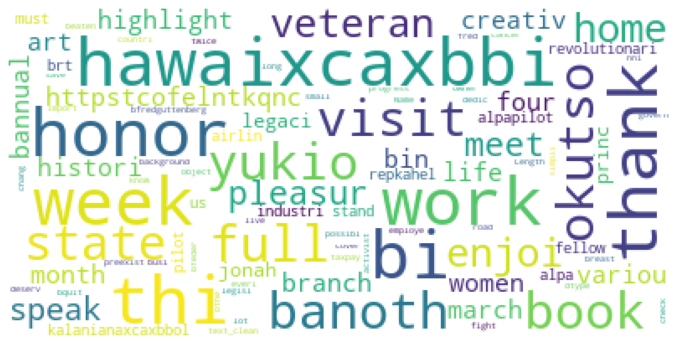

In [ ]:
import matplotlib.pyplot as plt

import matplotlib as mpl
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=100
                         ).generate(str(df_democr.text_clean))
print("Word Cloud (i.e., most used words), for tweets of Democrats:")
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

Word Cloud (i.e., most used words), for tweets of Repubblican:


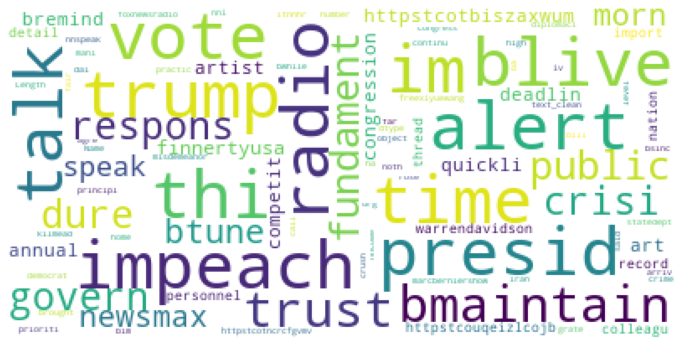

In [ ]:
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=100
                         ).generate(str(df_repubbl.text_clean))
print("Word Cloud (i.e., most used words), for tweets of Repubblican:")
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

We are now going to create the usual vocabulary matrix using "CountVectorizer".



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
vectorizer = CountVectorizer(
    analyzer='word',       
    min_df=3,# minimum required occurences of a word 
    stop_words='english',# remove stop words
    lowercase=True,# convert all words to lowercase
    token_pattern='[a-zA-Z0-9]{3,}',)# num chars > 3
    #max_features=5000,# max number of unique words   
                             
data_matrix = vectorizer.fit_transform(df_all.text_clean) 
data_matrix

<37624x8840 sparse matrix of type '<class 'numpy.int64'>'
	with 329732 stored elements in Compressed Sparse Row format>

In [ ]:
#df_all

In the next cells, we define the characteristics of the LDA model we want to use. One caveat is that we have to decide how many topics we want to fine with our model. In this project, we selected 6 topics.

In [ ]:
lda_model = LatentDirichletAllocation(
n_components=6, # Number of topics
learning_method='online',
random_state=20,       
n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_matrix)

Note that the cell above takes about 2 mins to be excute!!

In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

     |████████████████████████████████| 1.7MB 5.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.3MB 270kB/s 
     |████████████████████████████████| 9.9MB 44.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136870 sha256=427c819734ae0f0be3ee16685c7ac2fbf2161632d7f92c1b9a59ac321a802cab
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyLDAvis
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      1.465019  -47.625065  1       1        20.760509
5      54.854797 -36.476795  2       1        18.308434
0      32.212929 -61.444572  3       1        16.808708
3      5.111096  -14.110332  4       1        15.932407
1      26.350170 -33.374702  5       1        14.515839
4      38.109818 -7.222781   6       1        13.674103, topic_info=          Term         Freq        Total Category  logprob  loglift
1424  brt       8504.000000  8504.000000  Default  30.0000  30.0000
258   american  1629.000000  1629.000000  Default  29.0000  29.0000
5281  new       1777.000000  1777.000000  Default  28.0000  28.0000
8804  year      1241.000000  1241.000000  Default  27.0000  27.0000
1612  busi      1214.000000  1214.000000  Default  26.0000  26.0000
...    ...              ...          ...      ...      ...      ...
972   biden     348.014889   668.357218   Topic6  -4.8814   1.3371 
5880  peopl     387.519567   1079.073237  Topic6  -4.7739   0.9656 
2515  democrat  310.613135   776.862671   Topic6  -4.9951   1.0730 
6915  right     300.988158   799.353825   Topic6  -5.0266   1.0129 
7979  thi       359.072543   4604.606346  Topic6  -4.8501  -0.5616 

[291 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
45    5      0.996483  access 
53    6      0.996418  account
70    1      0.241496  act    
70    2      0.756632  act    
70    4      0.002473  act    
...  ..           ...  ...    
8726  1      0.998906  women  
8737  1      0.799720  work   
8737  3      0.199675  work   
8743  5      0.997733  world  
8804  3      0.999630  year   

[328 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 1, 4, 2, 5])

In [ ]:
for i,topic in enumerate(lda_model.components_):
  print(f'Top 10 words for topic #{i}:')
  print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
  print('\n')

Top 10 words for topic #0:
['great', 'hous', 'bwe', 'small', 'need', 'thi', 'busi', 'year', 'new', 'brt']


Top 10 words for topic #1:
['hall', 'right', 'celebr', 'relief', 'amp', 'health', 'care', 'countri', 'famili', 'brt']


Top 10 words for topic #2:
['commun', 'thi', 'congress', 'honor', 'amp', 'nation', 'thank', 'offic', 'work', 'brt']


Top 10 words for topic #3:
['help', 'todai', 'counti', 'discuss', 'join', 'talk', 'bthank', 'hous', 'presid', 'thi']


Top 10 words for topic #4:
['bproud', 'law', 'dai', 'come', 'trump', 'visit', 'make', 'thei', 'bthe', 'american']


Top 10 words for topic #5:
['like', 'btodai', 'want', 'colleagu', 'pass', 'join', 'act', 'live', 'amp', 'brt']




In [ ]:
topic_values = lda_model.transform(data_matrix)
df_all['Topic'] = topic_values.argmax(axis=1)

In [ ]:
df_all.head(4)

,Unnamed: 0,text,Created_at,Tweet_ID,Geo,favorite_count,Language,retweet_count,coordinates,if_retweet,screen_name,User_name,User_location,User_description,followers_count,verified_user,url_user,id_user,hashtags,urls,user_name,twitter_id,party_name,state,office_title,account_type,first_name,middle_name,last_name,suffix,status,collecting,showing,bioguide_id,gender,fec_candidate_id,district,branch,_merge,text_clean,Topic
0,0,b'Maintaining trust with the public is the mos...,2021-03-26 19:34:35,1375531646867374083,NaN,82,en,52,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/WuKSjiJZC9', 'expanded_...",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,bmaintain trust with the public is the most fu...,2
1,1,b'Tune into @newsmax this morning at 7:50 ET\x...,2021-03-26 11:10:39,1375404829812621313,NaN,4,en,0,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/TBIsZAxWuM', 'expanded_...",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,btune into newsmax thi morn at be speak with f...,0
2,2,b'Reminder to #WI05 artists \xf0\x9f\x91\x89 t...,2021-03-25 13:38:07,1375079551991230465,NaN,2,en,0,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,"[{'text': 'WI05', 'indices': [12, 17]}]","[{'url': 'https://t.co/UQeizLcojB', 'expanded_...",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,bremind to artist the deadlin for the annual c...,1
3,3,b'\xf0\x9f\xa7\xb5Great thread from my colleag...,2021-03-24 20:28:22,1374820406868205579,NaN,4,en,0,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin",Official account for Congressman Scott Fitzger...,8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/TNcrCFgvMV', 'expanded_...",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,thread from my colleagu warrendavidson detail ...,5


In [ ]:
df_all.Topic.value_counts()

2    8788
5    7196
0    6525
3    6015
1    4755
4    4345
Name: Topic, dtype: int64

How can we "labeled" these topics? (Note that one "tricky" part of Topic Modeling is to understand what type of categorization the algorithm did. In some works, researchers use the knowledge of "field experts", in order to label the topic categorized).

Another way to try to understand what these topics are about is to examine directly which tweets/texts belong to a certain category.

Let's see what are some of the tweets about Topic N.1, and Topic N.2:

In [ ]:
df_all[df_all['Topic']==0].head(10)

,Unnamed: 0,text,Created_at,Tweet_ID,Geo,favorite_count,Language,retweet_count,coordinates,if_retweet,screen_name,User_name,User_location,User_description,followers_count,verified_user,url_user,id_user,hashtags,urls,user_name,twitter_id,party_name,state,office_title,account_type,first_name,middle_name,last_name,suffix,status,collecting,showing,bioguide_id,gender,fec_candidate_id,district,branch,_merge,text_clean,female_talking,Topic
1,1,b'Tune into @newsmax this morning at 7:50 ET\xe2\x80\x94I\xe2\x80\x99ll be speaking with @FinnertyUSA about the Evers Administration\xe2\x80\x99s data\xe2\x80\xa6 https://t.co/TBIsZAxWuM',2021-03-26 11:10:39,1375404829812621313,NaN,4,en,0,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin","Official account for Congressman Scott Fitzgerald, proudly serving Wisconsin’s Fifth District. #WI05",8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/TBIsZAxWuM', 'expanded_url': 'https://twitter.com/i/web/status/1375404829812621313', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,btune into newsmax thi morn at be speak with finnertyusa about the ever httpstcotbiszaxwum,0,0
6,6,b'I want to thank all farmers and ag workers in #WI05 on this #NationalAgDay. Thank you for your tireless work to sup\xe2\x80\xa6 https://t.co/L7ykDBohN1',2021-03-23 17:04:22,1374406679882727435,NaN,9,en,1,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin","Official account for Congressman Scott Fitzgerald, proudly serving Wisconsin’s Fifth District. #WI05",8598,True,https://t.co/7rWSAAN9xM,1004891731,"[{'text': 'WI05', 'indices': [46, 51]}, {'text': 'NationalAgDay', 'indices': [60, 74]}]","[{'url': 'https://t.co/L7ykDBohN1', 'expanded_url': 'https://twitter.com/i/web/status/1374406679882727435', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,bi want to thank all farmer and ag worker in on thi nationalagdai thank you for your tireless work to,0,0
11,11,"b'I spoke w/ @MacIverWisc this week about the $1.9 budget reconciliation. Bottom line, this was a bill full of libera\xe2\x80\xa6 https://t.co/ulVDeboYHS'",2021-03-19 17:51:32,1372968998715949066,NaN,14,en,1,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin","Official account for Congressman Scott Fitzgerald, proudly serving Wisconsin’s Fifth District. #WI05",8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/ulVDeboYHS', 'expanded_url': 'https://twitter.com/i/web/status/1372968998715949066', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,bi spoke w maciverwisc thi week about the budget reconcili bottom line thi wa a bill full of httpstcoulvdeboyh,0,0
14,14,b'I joined Bill Osmulski yesterday on the @MacIverWisc Newsmakers podcast to talk about the Democrats $1.9 trillion b\xe2\x80\xa6 https://t.co/UKWR1f80ho',2021-03-18 15:14:49,1372567172191563780,NaN,6,en,1,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin","Official account for Congressman Scott Fitzgerald, proudly serving Wisconsin’s Fifth District. #WI05",8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/UKWR1f80ho', 'expanded_url': 'https://twitter.com/i/web/status/1372567172191563780', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,bi join bill osmulski yesterdai on the maciverwisc newsmak podcast to talk about the democrat trillion,0,0
19,19,"b'Bottom line, this bill funds

In [ ]:
df_all[df_all['Topic']==4]

,Unnamed: 0,text,Created_at,Tweet_ID,Geo,favorite_count,Language,retweet_count,coordinates,if_retweet,screen_name,User_name,User_location,User_description,followers_count,verified_user,url_user,id_user,hashtags,urls,user_name,twitter_id,party_name,state,office_title,account_type,first_name,middle_name,last_name,suffix,status,collecting,showing,bioguide_id,gender,fec_candidate_id,district,branch,_merge,text_clean,female_talking,Topic
4,4,"b'While we all agree on the principle of fairness, in practice, this bill is far from it.\n\nH.R. 7 crushes the Christm\xe2\x80\xa6 https://t.co/hO0Igd3lpJ'",2021-03-24 19:28:15,1374805279695601671,NaN,24,en,5,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin","Official account for Congressman Scott Fitzgerald, proudly serving Wisconsin’s Fifth District. #WI05",8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/hO0Igd3lpJ', 'expanded_url': 'https://twitter.com/i/web/status/1374805279695601671', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,bwhile we all agre on the principl of fair in practic thi bill is far from itnnhr crush the,0,4
9,9,"b'Today, I sent a letter to Gov. Evers on the reclassifying of 1,000 COVID-19 deaths as reported by the Journal Senti\xe2\x80\xa6 https://t.co/WZItRPzgcr'",2021-03-22 21:02:33,1374104233293795332,NaN,4,en,0,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin","Official account for Congressman Scott Fitzgerald, proudly serving Wisconsin’s Fifth District. #WI05",8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/WZItRPzgcr', 'expanded_url': 'https://twitter.com/i/web/status/1374104233293795332', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,btodai i sent a letter to gov ever on the reclassifi of death as report by the journal httpstcowzitrpzgcr,0,4
17,17,b'This story underscores just how challenging pandemic-imposed school shutdowns have been for Wisconsin students. Fai\xe2\x80\xa6 https://t.co/6VUmxRawkk',2021-03-16 18:26:38,1371890666624708608,NaN,3,en,0,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin","Official account for Congressman Scott Fitzgerald, proudly serving Wisconsin’s Fifth District. #WI05",8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/6VUmxRawkk', 'expanded_url': 'https://twitter.com/i/web/status/1371890666624708608', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,bthi stori underscor just how challeng pandemicimpos school shutdown have been for wisconsin student,0,4
38,38,b'H.R. 1 puts politicians ahead of the American people and codifies nationwide election changes made at the state lev\xe2\x80\xa6 https://t.co/DG970iL4VF',2021-03-02 17:28:48,1366802682225303553,NaN,77,en,37,NaN,False,RepFitzgerald,Rep. Scott Fitzgerald,"Juneau, Wisconsin","Official account for Congressman Scott Fitzgerald, proudly serving Wisconsin’s Fifth District. #WI05",8598,True,https://t.co/7rWSAAN9xM,1004891731,[],"[{'url': 'https://t.co/DG970iL4VF', 'expanded_url': 'https://twitter.com/i/web/status/1366802682225303553', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]",RepFitzgerald,1004891731,Republican,WI,House Representative,official,Scott,NaN,Fitzgerald,NaN,1,True,True,F000471,M,H0WI05113,5.0,H,both,bhr put politician ahead of the american peopl and codifi nationwid elect chang made at the state,0,4
39,39,"b'The House will vote on H.R. 1, #ForThePoliticians Act this week. Here are a few regressive ideas Democrats are advo\xe2\x80\xa6 https://t.co/5dSE84SWNT'

Other references, for Topic Modeling:
- https://medium.datadriveninvestor.com/trump-tweets-topic-modeling-using-latent-dirichlet-allocation-e4f93b90b6fe
- https://ourcodingclub.github.io/tutorials/topic-modelling-python/
- https://towardsdatascience.com/lda-topic-modeling-with-tweets-deff37c0e131